In [13]:
import numpy as np
import pandas as pd
import os
import glob
import sys
from tqdm import tqdm 
from tabulate import tabulate
import statistics as stat
import scipy.spatial as spatial
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import joblib #for later improvements
import matplotlib.pyplot as plt
import matplotlib as mp

In [14]:
# Currently active probe design project
folder = '/mnt/data/Probe_design/Pipeline/data/'

#folder = '/mnt/data/Probe_design/Projects/Diego Macedo RNA on plasmodium/data/'

probesummary = folder + 'probe_summary_probelet.tsv'

probelist = pd.read_csv(probesummary,sep="\t",header=0)
probelist=probelist.sort_values(by=['roi','nOligos','pw'])

print("Total count of probe candidates: "+str(len(probelist)))

cutoff_dmean = 5

Total count of probe candidates: 273


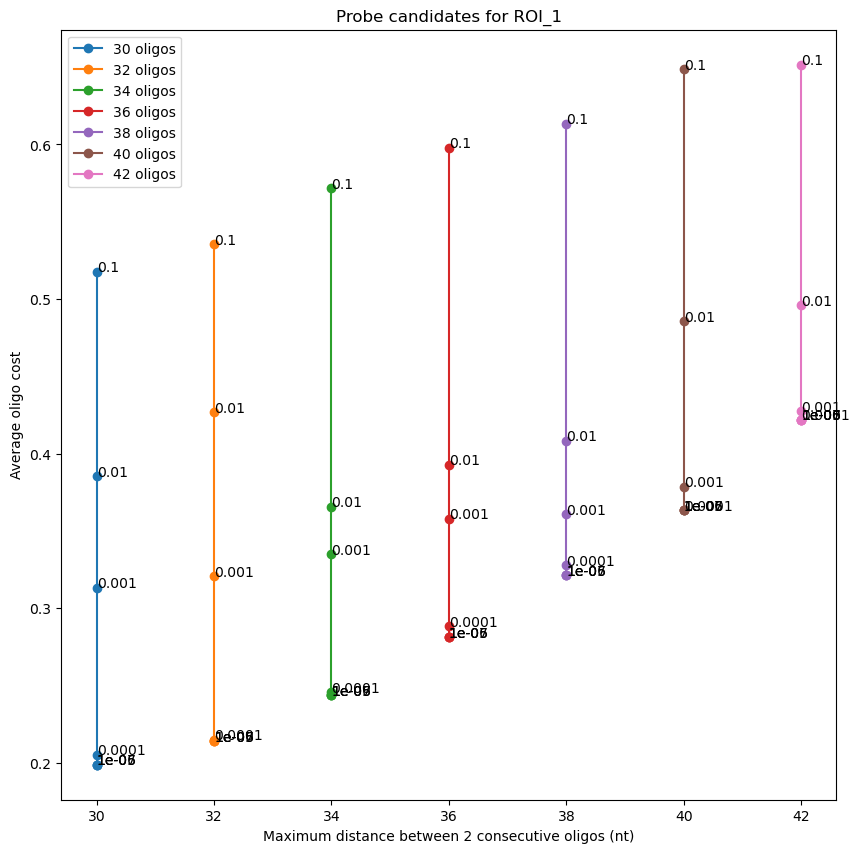

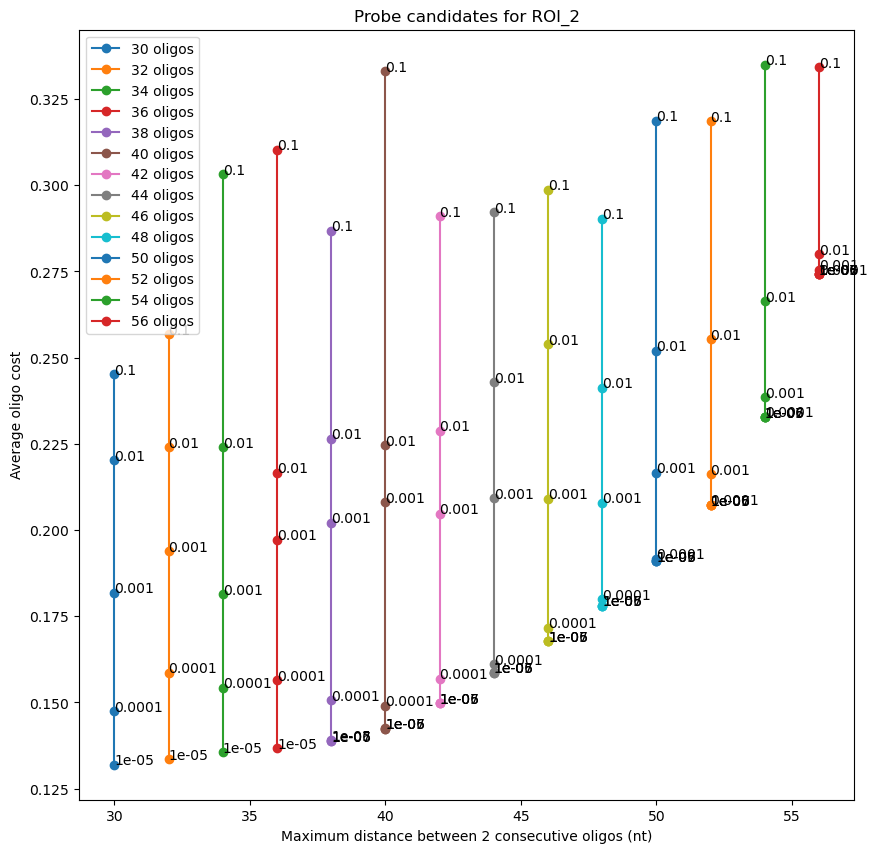

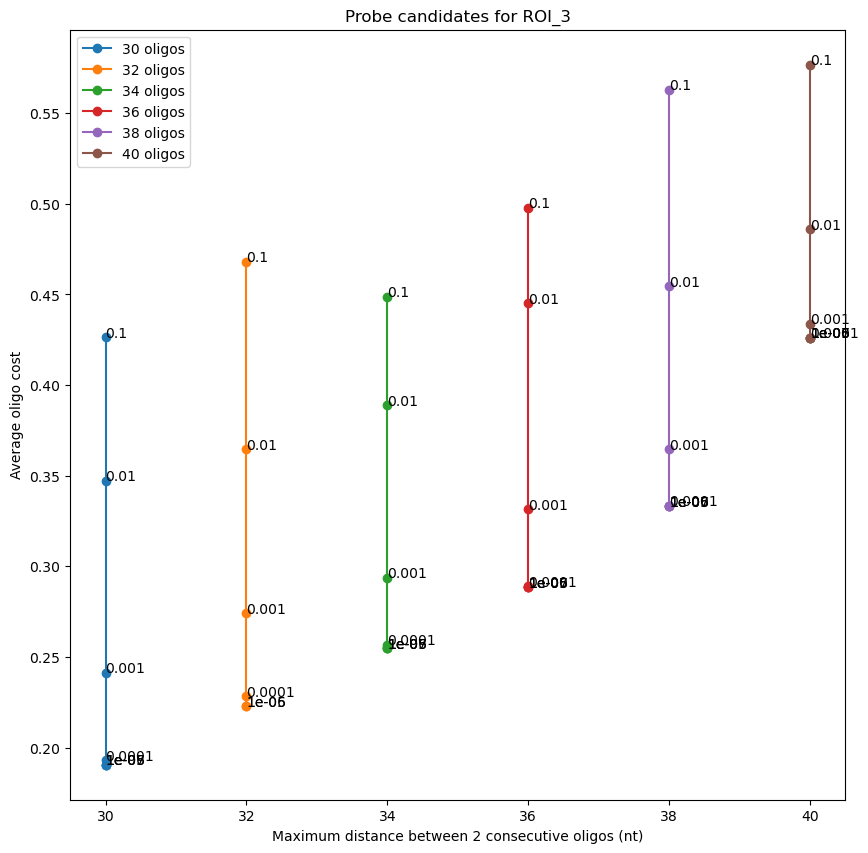

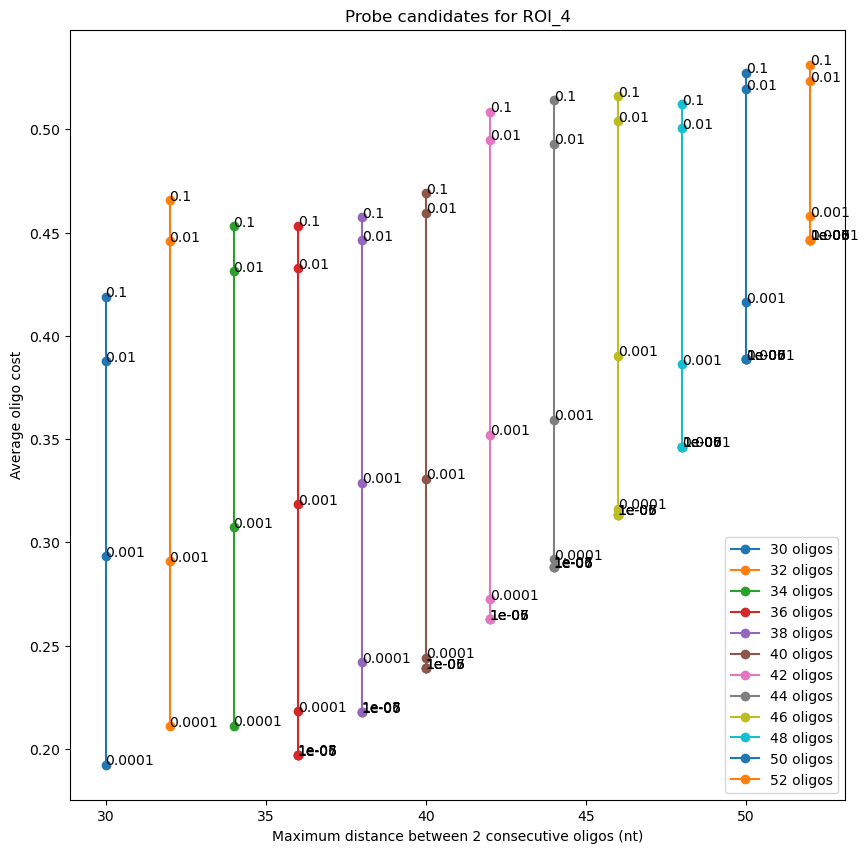

In [24]:
# for each ROI, plot the probe candidates obtained for different pair weights or different numbers of oligos
rois = pd.unique(probelist.roi)

#mode = 'off_target_cc'
#mode = 'cumul'
#mode = 'off_target_cumul'
mode = 'oligo_cost'


for k in range(len(rois)):
    probesets = pd.unique(probelist[probelist.roi == rois[k]].nOligos)

    # one figure per ROI
    plt.figure(figsize=(10,10))
    # one curve per probe set
    for j in range(len(probesets)):
        # Average distance between consec oligos (% probe length)
        x = np.divide(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'],probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size']).tolist()
        
        # Max distance between consec oligos (% region length)
        #x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_max(%RegionSize)'].tolist()

        # Max distance between consec oligos (# nt)
        #x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_max'].tolist()
        
        # Average distance between consec oligos (# nt)
        # x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'].tolist()

        # Number of oligos
        x = probesets[j]*np.ones(len(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()))

        # Probe length (nt)
        #x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()

        if mode == 'cumul':
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_cumulMM.tolist()
        elif mode == 'off_target_cc':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'off_target_cumul':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'oligo_cost':
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_oligo_cost.tolist() 
        
        labels = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].pw.tolist()
        plt.plot(x, y,"-o", label=(str(probesets[j])+" oligos"))

        for i, txt in enumerate(labels):
            plt.annotate(txt, (x[i], y[i]))

    #plt.xlabel("Number of oligos")
    #plt.xlabel("Maximum distance between 2 consecutive oligos (%region length)")
    plt.xlabel("Maximum distance between 2 consecutive oligos (nt)")
    #plt.xlabel("Probe size (nt)")
    if mode == 'cumul':
        plt.ylabel("Average cumulated mismatch count")
    elif mode == 'off_target_cumul':  
        plt.ylabel("Average worst sublength match")
    elif mode == 'off_target_cc':  
        plt.ylabel("Average longest potential consecutive match")
    elif mode == 'oligo_cost':
        plt.ylabel("Average oligo cost")

    plt.title("Probe candidates for %s" % rois[k])
    plt.legend()
    plt.show()

# unique_labels = set(labels555)
# core_samples_mask = np.zeros_like(labels555, dtype=bool)

# # Random color map: 
# vals = np.linspace(0,1,256)
# np.random.shuffle(vals)
# cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
# colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]


(273, 36)
(255, 36)


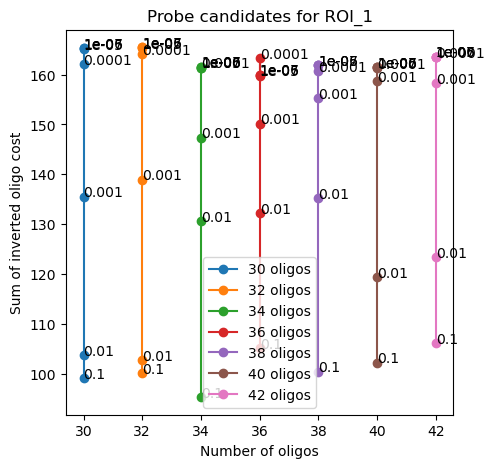

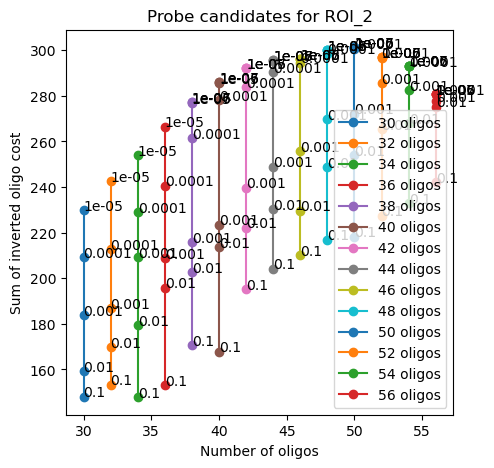

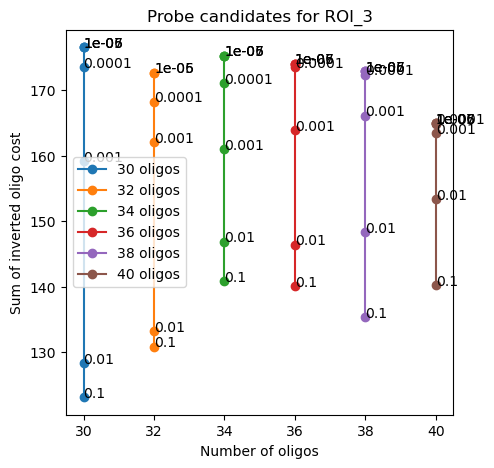

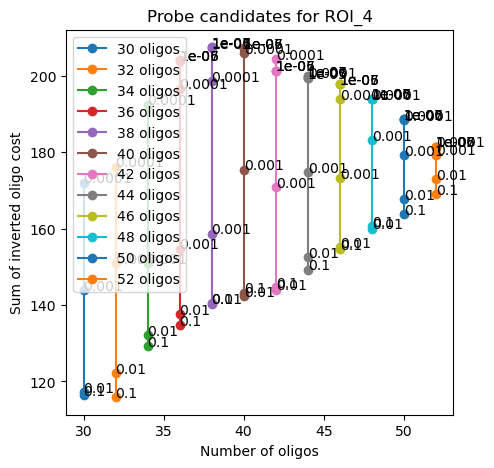

In [16]:
# for each ROI, plot the probe candidates obtained for different pair weights or different numbers of oligos
rois = pd.unique(probelist.roi)
print(probelist.shape)
probelist = probelist[probelist['d_max(%RegionSize)']<cutoff_dmean]
print(probelist.shape)

#mode = 'off_target_cc'
#mode = 'cumul'
#mode = 'off_target_cumul'
mode = 'oligo_cost'


for k in range(len(rois)):

    # Apply filter on distance between consecutive oligos
    probesets = pd.unique(probelist[probelist.roi == rois[k]].nOligos)

    # one figure per ROI
    plt.figure(figsize=(5,5))
    # one curve per probe set
    for j in range(len(probesets)):
        # Average distance between consec oligos (% probe length)
        # x = np.divide(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'],probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size']).tolist()
        
        # Average distance between consec oligos (% region length)
        # x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean(%RegionSize)'].tolist()
        
        # Average distance between consec oligos (# nt)
        # x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'].tolist()

        # Number of oligos
        x = probesets[j]*np.ones(len(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()))

        # Probe length (nt)
        #x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()


        if mode == 'cumul':
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_cumulMM.tolist()
        elif mode == 'off_target_cc':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'off_target_cumul':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'oligo_cost':
            #ytemp = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_oligo_cost.tolist() 
            #y = np.multiply(x,ytemp)
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].sum_inv_cost.tolist()
        
        labels = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].pw.tolist()
        plt.plot(x, y,"-o", label=(str(probesets[j])+" oligos"))

        for i, txt in enumerate(labels):
            plt.annotate(txt, (x[i], y[i]))

    #plt.xlabel("Average distance between consecutive oligos (nt)")
    plt.xlabel("Number of oligos")
    #plt.xlabel("Probe size (nt)")
    if mode == 'cumul':
        plt.ylabel("Average cumulated mismatch count")
    elif mode == 'off_target_cumul':  
        plt.ylabel("Average worst sublength match")
    elif mode == 'off_target_cc':  
        plt.ylabel("Average longest potential consecutive match")
    elif mode == 'oligo_cost':
        plt.ylabel("Sum of inverted oligo cost")

    plt.title("Probe candidates for %s" % rois[k])
    plt.legend()
    plt.show()

# unique_labels = set(labels555)
# core_samples_mask = np.zeros_like(labels555, dtype=bool)

# # Random color map: 
# vals = np.linspace(0,1,256)
# np.random.shuffle(vals)
# cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
# colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]


(255, 36)
(255, 36)


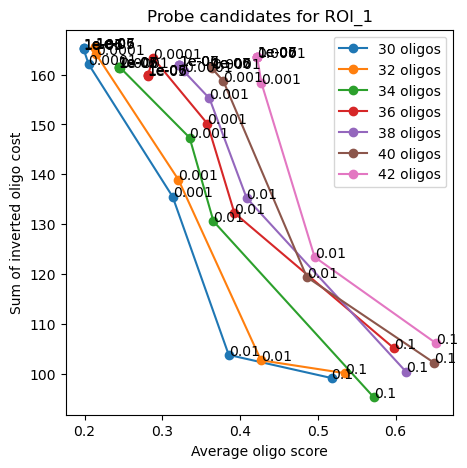

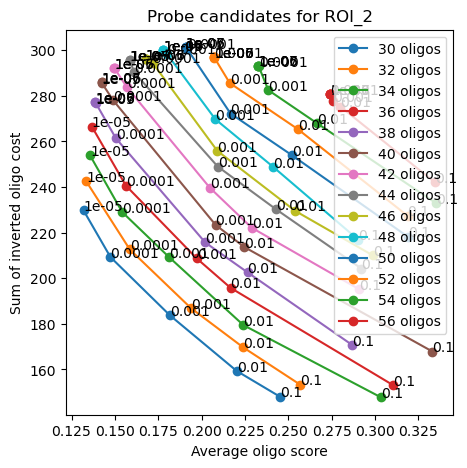

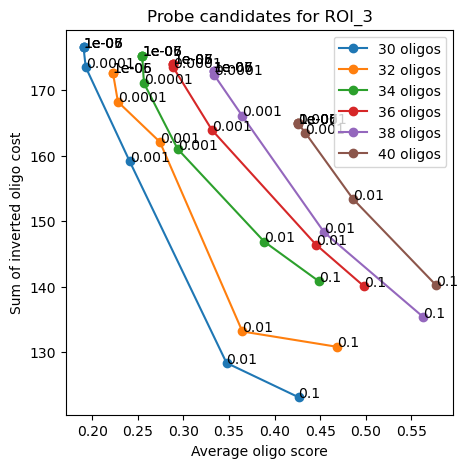

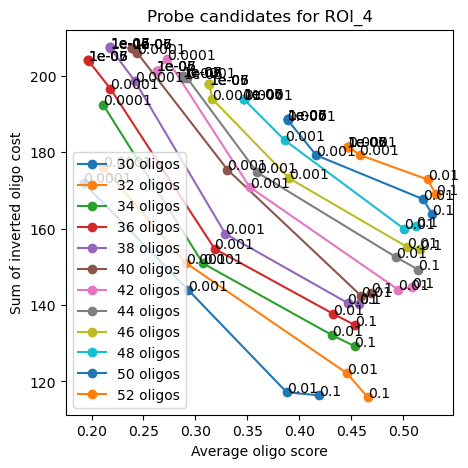

In [20]:
# for each ROI, plot the probe candidates obtained for different pair weights or different numbers of oligos
rois = pd.unique(probelist.roi)
print(probelist.shape)
probelist = probelist[probelist['d_max(%RegionSize)']<cutoff_dmean]
print(probelist.shape)

#mode = 'off_target_cc'
#mode = 'cumul'
#mode = 'off_target_cumul'
mode = 'oligo_cost'


for k in range(len(rois)):

    # Apply filter on distance between consecutive oligos
    probesets = pd.unique(probelist[probelist.roi == rois[k]].nOligos)

    # one figure per ROI
    plt.figure(figsize=(5,5))
    # one curve per probe set
    for j in range(len(probesets)):
        # Average distance between consec oligos (% probe length)
        # x = np.divide(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'],probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size']).tolist()
        
        # Average distance between consec oligos (% region length)
        # x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean(%RegionSize)'].tolist()
        
        # Average distance between consec oligos (# nt)
        # x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['d_mean'].tolist()

        # Number of oligos
        #x = probesets[j]*np.ones(len(probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()))

        # Probe length (nt)
        #x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])]['probe_size'].tolist()

        # Mean oligo cost
        x = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_oligo_cost.tolist() 


        if mode == 'cumul':
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_cumulMM.tolist()
        elif mode == 'off_target_cc':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'off_target_cumul':    
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_closestMM.tolist()
        elif mode == 'oligo_cost':
            #ytemp = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].mean_oligo_cost.tolist() 
            #y = np.multiply(x,ytemp)
            y = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].sum_inv_cost.tolist()
        
        labels = probelist[(probelist.roi == rois[k]) & (probelist.nOligos == probesets[j])].pw.tolist()
        plt.plot(x, y,"-o", label=(str(probesets[j])+" oligos"))

        for i, txt in enumerate(labels):
            plt.annotate(txt, (x[i], y[i]))

    #plt.xlabel("Average distance between consecutive oligos (nt)")
    plt.xlabel("Average oligo score")
    #plt.xlabel("Probe size (nt)")
    if mode == 'cumul':
        plt.ylabel("Average cumulated mismatch count")
    elif mode == 'off_target_cumul':  
        plt.ylabel("Average worst sublength match")
    elif mode == 'off_target_cc':  
        plt.ylabel("Average longest potential consecutive match")
    elif mode == 'oligo_cost':
        plt.ylabel("Sum of inverted oligo cost")

    plt.title("Probe candidates for %s" % rois[k])
    plt.legend()
    plt.show()

# unique_labels = set(labels555)
# core_samples_mask = np.zeros_like(labels555, dtype=bool)

# # Random color map: 
# vals = np.linspace(0,1,256)
# np.random.shuffle(vals)
# cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
# colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]
